# The Daubechies D4 Wavelet Tranform

In [1]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt
from time import time


def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))
     
     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [2]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        normalized = np.copy(result_V)
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}"); return np.ones_like(image), np.ones_like(image)

In [3]:
def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width):
    new_transform = np.copy(transform_result)
    image = []
    
    if (scale == 1) :
        daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
        
        result_H = np.dot(daubechies_coeffs_transpose, transform_result)
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_img = width // (2 ** scale) * 2
        daubechies_coeffs_transpose = np.transpose(function_daubechies_coeffs(new_transform[:tam_img, :tam_img]))
        
        result_H = np.dot(daubechies_coeffs_transpose, new_transform[:tam_img, :tam_img])
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)

        new_transform[:len(image), :len(image)] = image

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(new_transform),new_transform,scale-1,new_transform.shape[0])

In [4]:
def zeros(image, scale):
    tam_img = image.shape[0] // (2 ** scale)
    image[:tam_img, :tam_img] = np.zeros((tam_img, tam_img))
    return image

## NUMERIC EXAMPLE

In [5]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")


Coeffs Matrix:
 [[ 0.483   0.8365  0.2241 -0.1294  0.      0.      0.      0.    ]
 [ 0.      0.      0.483   0.8365  0.2241 -0.1294  0.      0.    ]
 [ 0.      0.      0.      0.      0.483   0.8365  0.2241 -0.1294]
 [ 0.2241 -0.1294  0.      0.      0.      0.      0.483   0.8365]
 [-0.1294 -0.2241  0.8365 -0.483   0.      0.      0.      0.    ]
 [ 0.      0.     -0.1294 -0.2241  0.8365 -0.483   0.      0.    ]
 [ 0.      0.      0.      0.     -0.1294 -0.2241  0.8365 -0.483 ]
 [ 0.8365 -0.483   0.      0.      0.      0.     -0.1294 -0.2241]]

Coeffs Matrix Transposed:
 [[ 0.483   0.      0.      0.2241 -0.1294  0.      0.      0.8365]
 [ 0.8365  0.      0.     -0.1294 -0.2241  0.      0.     -0.483 ]
 [ 0.2241  0.483   0.      0.      0.8365 -0.1294  0.      0.    ]
 [-0.1294  0.8365  0.      0.     -0.483  -0.2241  0.      0.    ]
 [ 0.      0.2241  0.483   0.      0.      0.8365 -0.1294  0.    ]
 [ 0.     -0.1294  0.8365  0.      0.     -0.483  -0.2241  0.    ]
 [ 0.      0.   

In [6]:
aP,cH,cV,cD = split_matrix(example)
scale = 1
dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,scale,example.shape[0])
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,scale,dwt.shape[0])

print(f"Original Matrix:\n {example}")
print(f"\nDirect daubechies Wavelet Transform\n {np.round(dwt,0)}")
print(f"\nInverse daubechies Wavelet Transform\n {np.round((idwt),0)}")

Original Matrix:
 [[38 28 24 28 37  2 13 23]
 [24 36 26 10 39 19 38 14]
 [ 9  1  6 18  9  9 21 45]
 [16 19 24 49 11 45  8 49]
 [32 11 36 13 21  7  7 32]
 [43  1 21 27  4 12 25 49]
 [32 14  8  7 21 17  5  5]
 [19  3 44 12  4 17 32 28]]

Direct daubechies Wavelet Transform
 [[ 58.  41.  42.  46.   3.  28.  13.   1.]
 [ 25.  53.  39.  62.  -7. -20. -30.  -9.]
 [ 38.  41.  19.  67.   3.  -3. -14.  28.]
 [ 34.  37.  27.  44.  20.  -6.   2.  15.]
 [-23. -20. -21.   9.  -0.   5.   5.  -1.]
 [  9.  -2.  -4. -17.  18.  17.  -1.   3.]
 [  5. -16.   7. -29. -19.  14.  -5.   7.]
 [  6.  15. -11.  -1. -12.  11. -14.   9.]]

Inverse daubechies Wavelet Transform
 [[38. 28. 24. 28. 37.  2. 13. 23.]
 [24. 36. 26. 10. 39. 19. 38. 14.]
 [ 9.  1.  6. 18.  9.  9. 21. 45.]
 [16. 19. 24. 49. 11. 45.  8. 49.]
 [32. 11. 36. 13. 21.  7.  7. 32.]
 [43.  1. 21. 27.  4. 12. 25. 49.]
 [32. 14.  8.  7. 21. 17.  5.  5.]
 [19.  3. 44. 12.  4. 17. 32. 28.]]


## IMAGES EXAMPLES

In [7]:
photo = 'imagen.jpg'

0.6707377433776855


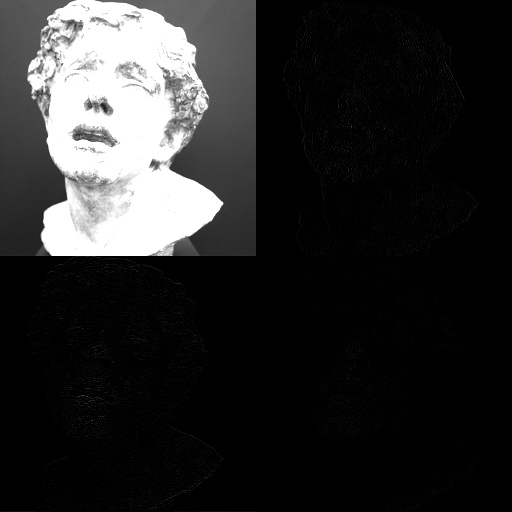

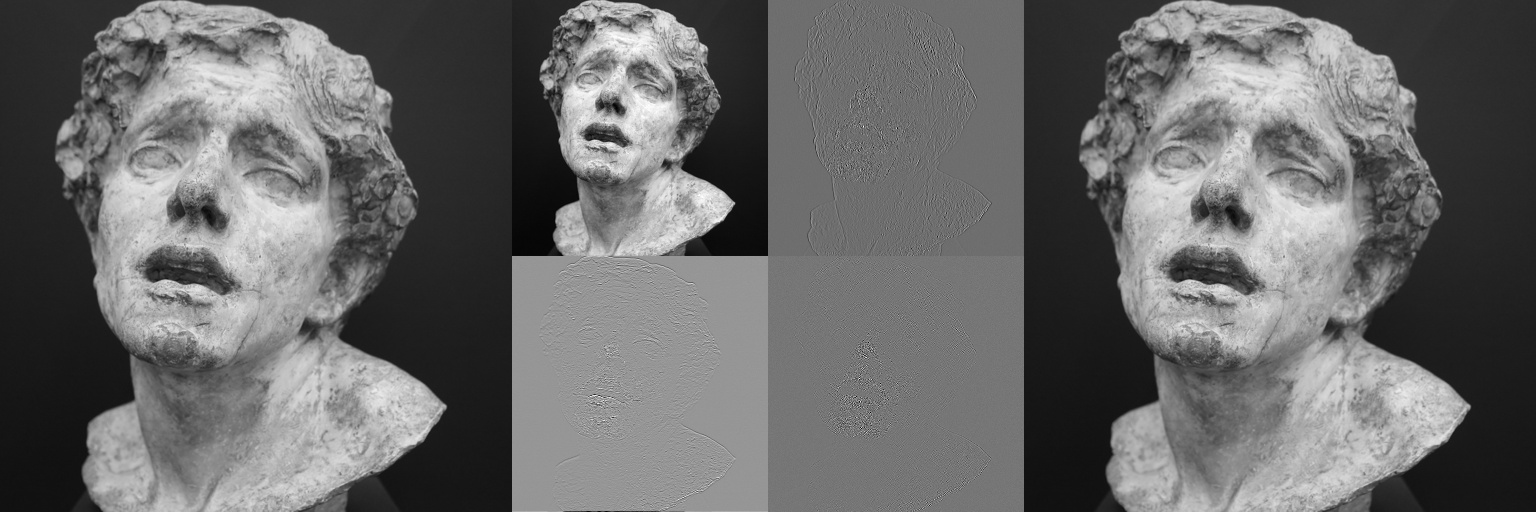

In [13]:
initial_time = time() 
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 1, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
# result_img = zeros(result_img, scale)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)
final_time = time()


execution_time = final_time - initial_time
print(execution_time)
imshow(result_img)
imshow(np.concatenate((array_photo, normalized, reconstructed), axis = 1))
